<a href="https://colab.research.google.com/github/gabrielfea/previsaoacoes/blob/main/analise_modelo_pred_acoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima
!pip install tensorflow
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import metrics
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn import preprocessing

from pmdarima import auto_arima

import yfinance as yf
yf.pdr_override()

from pandas_datareader import data as pdr

import datetime
from datetime import date
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff
import plotly.offline as py
from plotly.subplots import make_subplots

from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten,TimeDistributed,RepeatVector
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout

tf.random.set_seed(123)
np.random.seed(123)
import random
random.seed(123)

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# Análise de Ação B3

In [3]:
def get(tickers,startdate,enddate):
   def data(ticker):
       return(pdr.get_data_yahoo(ticker, start=startdate,end=enddate))
   datas = map(data,tickers)
   all_data = pd.concat(datas, keys=tickers, names=['Ticker', 'Date'])
   return all_data

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [6]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [7]:
def preve_acao(asset,imprime_grafico=False):
  #asset = "ITUB4.SA"
  tickers = [asset]
  startdate = date(2000,1,1)
  enddate = date.today()

  data = get(tickers,startdate,enddate)


  #data.loc[asset].tail()

  df = data.loc[asset,["Close","High","Low"]]
  df_cycle,df_trend = hpfilter(df["Close"], lamb=1600)
  #df["Close"].plot(figsize=(15,6)).autoscale(axis='x',tight=True)
  #df_trend.plot(figsize=(15,6)).autoscale(axis='x',tight=True)
  df["Trend"] = df_trend
  df_close = df["Close"]
  tamanho = len(df["Close"])

  h = 90
  predition_X = df.tail(h)
  uni_data = df.drop(df.tail(h).index)

  x_scaler = preprocessing.StandardScaler()
  y_scaler = preprocessing.StandardScaler()
  dataX = x_scaler.fit_transform(df)
  dataY = y_scaler.fit_transform(df[['Trend']]) #y_scaler.fit_transform(np.array(df).reshape(-1, 1))

  hist_window = 60
  horizon = h

  index_prev = data.loc[asset].index[-h:]
  index_prev

  from pandas.tseries.holiday import USFederalHolidayCalendar
  from pandas.tseries.offsets import CustomBusinessDay
  us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
  index_prev_oficial = pd.period_range(start=index_prev[-1], periods=h+1, freq=us_bd)[1:]


  TRAIN_SPLIT = int((tamanho-h)*0.80)
  x_train_multi, y_train_multi = custom_ts_multi_data_prep(
      dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
  x_val_multi, y_val_multi= custom_ts_multi_data_prep(
      dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

  BATCH_SIZE = 60
  BUFFER_SIZE = 60

  train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
  train_data_multi = train_data_multi.cache().batch(BATCH_SIZE).repeat()

  val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
  val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

  LSTM_model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(60, input_shape=x_train_multi.shape[-2:],return_sequences=True),
      tf.keras.layers.LSTM(units=60,return_sequences=True),
      tf.keras.layers.LSTM(units=60),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(units=horizon),
  ])
  LSTM_model.compile(optimizer='adam', loss='mse')

  model_path = f'drive/MyDrive/modelos_ia_prev_acoes/{asset[:5]}.h5'

  try:
    Trained_model = tf.keras.models.load_model(model_path)
    #Trained_model.summary()
  except:
    print("Modelo não treinado ainda!")
    EVALUATION_INTERVAL = 100
    EPOCHS = 150
    history = LSTM_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])
    Trained_model = tf.keras.models.load_model(model_path)
    #Trained_model.summary()

  data_val = x_scaler.fit_transform(uni_data.tail(hist_window))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
  Predicted_results = Trained_model.predict(val_rescaled)
  #Predicted_results

  df2 = predition_X
  df2_cycle,df2_trend = hpfilter(df2["Close"], lamb=1600)
  df2["Trend"] = df2_trend
  data_pred = x_scaler.fit_transform(df2.tail(hist_window))
  pred_rescaled = data_pred.reshape(1, data_pred.shape[0], data_pred.shape[1])
  Predicted_results_oficial = Trained_model.predict(pred_rescaled)
  Predicted_results_oficial_Inv_trans = y_scaler.inverse_transform(Predicted_results_oficial.reshape(-1,1))
  Predicted_results_oficial_Inv_trans = pd.DataFrame(Predicted_results_oficial_Inv_trans, columns=['Trend'], index=index_prev_oficial)
  Predicted_results_oficial_Inv_trans_cycle,Predicted_results_oficial_Inv_trans_trend = hpfilter(Predicted_results_oficial_Inv_trans, lamb=1600)
  ajuste2 = Predicted_results_oficial_Inv_trans_trend[0]-df_close.tail(h+1)[-1]
  Predicted_results_oficial_Inv_trans = Predicted_results_oficial_Inv_trans-ajuste2
  Predicted_results_oficial_Inv_trans_trend = Predicted_results_oficial_Inv_trans_trend-ajuste2

  Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results.reshape(-1,1))
  Predicted_results_Inv_trans = pd.DataFrame(Predicted_results_Inv_trans, columns=['Trend'], index=index_prev)
  Predicted_results_Inv_trans_cycle,Predicted_results_Inv_trans_trend = hpfilter(Predicted_results_Inv_trans, lamb=1600)
  ajuste = Predicted_results_Inv_trans_trend[0]-df_close.tail(h+1)[0]
  Predicted_results_Inv_trans_trend = Predicted_results_Inv_trans_trend-ajuste
  Predicted_results_Inv_trans = Predicted_results_Inv_trans-ajuste

  validate = pd.DataFrame(df_close.tail(h), columns=['Close'], index=index_prev)
  alta_estimada = round((max(Predicted_results_oficial_Inv_trans_trend)/Predicted_results_oficial_Inv_trans_trend[0]-1)*100,2)
  baixa_estimada = round((min(Predicted_results_oficial_Inv_trans_trend)/Predicted_results_oficial_Inv_trans_trend[0]-1)*100,2)
  MAPE = mean_absolute_percentage_error(validate,Predicted_results_Inv_trans_trend)
  r2 = metrics.r2_score(validate,Predicted_results_Inv_trans_trend)

  if imprime_grafico == True:

    print()
    print("_"*75)
    print(asset)
    timeseries_evaluation_metrics_func(validate,Predicted_results_Inv_trans_trend)
    print(f'Alta estimada: {alta_estimada} %')

    plt.plot(df_close.tail(h+100))
    #plt.plot( Predicted_results_Inv_trans)
    #plt.plot( Predicted_results_oficial_Inv_trans)
    plt.plot(Predicted_results_Inv_trans_trend)
    plt.plot(Predicted_results_oficial_Inv_trans_trend)
    plt
    plt.title("Actual vs Predicted")
    plt.ylabel(f'{asset}')
    plt.legend(('Actual','validation_trend','predicted_trend'))
    plt.show()


  return [alta_estimada,baixa_estimada,MAPE,r2]

In [8]:
assets_df = pd.read_csv('drive/MyDrive/assets.csv', delimiter=";")

In [9]:
analise_df = pd.DataFrame(columns=['Asset','Alta_estimada (%)','Baixa_estimada (%)', 'MAPE','r2'])
for i in assets_df.iloc[300:]["codigo"]:
  if i not in ["ALOS3","CACR11","RZAT11","BROF11","GARE11","RBRX11","TRBL11","SPXS11","TVRI11","VCRI11","A1MT34","INEP4","S2TA34"]:
    print()
    print(i)
    result = preve_acao(i+".SA")
    analise_df = analise_df.append({'Asset':i,'Alta_estimada (%)':result[0],'Baixa_estimada (%)':result[1],'MAPE':result[2],'r2':result[3]},ignore_index=True)


IFCM3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 50ms/step

ITLC34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 87ms/step

INTB3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 68ms/step

MYPK3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 148ms/step

RANI3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 34ms/step

IRBR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

ITSA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

ITSA4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 36ms/step

ITUB3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 35ms/step

ITUB4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

JALL3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 44ms/step

JBSS3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

JDCO34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

JHSF3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 49ms/step

JNJB34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

JPMC34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

JSLG3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

KEPL3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

K2CG34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

KLBN11


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

KHCB34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

LAVV3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

LILY34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

L1YG34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

RENT3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 53ms/step

LOGG3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

LOGN3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

AMAR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

LREN3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 34ms/step

LPSB3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

L1MN34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

LUPA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 37ms/step

LWSA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 50ms/step

MDIA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

MGLU3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 34ms/step

POMO3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 50ms/step

POMO4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

MRFG3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 45ms/step

MSCD34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

MATD3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 39ms/step

MCDC34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

M2PW34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 38ms/step

CASH3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 50ms/step

MELK3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 45ms/step

MELI34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

BMEB3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 41ms/step

BMEB4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

MRCK34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

M1TA34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

LEVE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

MUTC34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

MSFT34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 49ms/step

MILS3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

BEEF3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

MTRE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 49ms/step

MBLY3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

M1RN34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

M1NS34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 53ms/step

MSBR34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

MOSC34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

MDNE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 45ms/step

MOVI3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

MRVE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

MLAS3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

MULT3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

N1DA34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 53ms/step

NEOE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 34ms/step

NGRD3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 42ms/step

NFLX34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 53ms/step

E1DU34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

N1EM34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

NEXT34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 48ms/step

NIKE34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

N1VO34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

NVDC34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

OXYP34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

OPCT3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

ODPV3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

ONCO3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

ORCL34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 41ms/step

ORVR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

OFSA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

PCAR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 45ms/step

PDTC3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 34ms/step

PAGS34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

PGMN3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

P2LT34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

P2AN34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

PYPL34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

P1DD34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

PEPB34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

PETR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 34ms/step

PETR4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

RECV3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 72ms/step

PRIO3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 34ms/step

PTNT4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

PETZ3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 50ms/step

PFIZ34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

PGCO34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 43ms/step

PINE4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 34ms/step

PLPL3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

PSSA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 46ms/step

PTBL3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

POSI3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

PRNR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 53ms/step

PFRM3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

P1LD34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

QCOM34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 82ms/step

QUAL3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 46ms/step

LJQQ3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

RADL3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

RAIZ4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

RAPT3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 49ms/step

RAPT4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 34ms/step

R1IN34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 43ms/step

RCSL3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 51ms/step

RDOR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

RIOT34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

RDNI3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 57ms/step


[*********************100%%**********************]  1 of 1 completed


R2BL34


1/1 [==============================] - 0s 29ms/step

ROMI3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

RAIL3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 37ms/step

SBSP3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

SSFO34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 48ms/step

SAPR11


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

BCSA34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

SANB11


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 45ms/step

STBP3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

SCAR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

SMTO3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 34ms/step

SCHW34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 44ms/step

S2EA34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

SEER3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

SRNA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

S2HO34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 42ms/step

S1BS34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

CSNA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

SIMN34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 49ms/step

SIMH3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

S1LG34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

SLCE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 48ms/step

SMFT3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

SNEC34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

S1PO34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 47ms/step

SGPS3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

SBUB34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

S2UI34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

SUZB3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

SYNE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

TAEE11


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 40ms/step

TSMC34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

T1TW34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 48ms/step

T1AL34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

TASA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

TASA4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

TRAD3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

TECN3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

TCSA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

TGMA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 39ms/step

T2DH34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 47ms/step

VIVT3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

TLNC34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 34ms/step

TEND3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 47ms/step

LAND3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 41ms/step

TSLA34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

TEXA34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

TIMS3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

SHOW3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

TOTS3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 38ms/step

TMCO34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

TFCO4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 72ms/step

T2TD34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

TRPL3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

TRPL4


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 49ms/step

RIGG34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step

TRIS3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

TPIS3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 28ms/step

TUPY3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

U1BE34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

UGPA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

UCAS3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

FIQE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 50ms/step

ULEV34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

UNIP6


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

UNHH34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 37ms/step

U2ST34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

U2PS34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

USIM3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

USIM5


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

VALE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 46ms/step

VLID3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

VAMO3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

VERZ34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

VSTE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

VBBR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

VISA34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

VITT3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

VIVA3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 49ms/step

VVEO3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 34ms/step

VIVR3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

VULC3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 46ms/step

WALM34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

DISB34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

LVTC3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

WEGE3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

WFCO34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

WEST3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 34ms/step

PORT3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 35ms/step

WIZC3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 45ms/step

YDUQ3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

ZAMP3


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

Z1TS34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 33ms/step

Z1OM34


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 31ms/step


#PREVISÃO PARA 3 MESES (60 PREGÕES)


### Maior alta estimada e maior baixa estimada em relação ao presente

In [10]:
sugestoes_df = analise_df[(analise_df['r2']>-0.1) & (analise_df['MAPE']<13) & (analise_df['Alta_estimada (%)']>5)].sort_values(by=['Alta_estimada (%)'],ascending=False)

In [11]:
sugestoes_df = sugestoes_df.join(assets_df.set_index('codigo'),on='Asset').reset_index(drop=True)


___________________________________________________________________________
___________________________________________________________________________
MAGAZ LUIZA


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

___________________________________________________________________________
MGLU3.SA
Evaluation metric results:-
MSE is : 0.05210136693314581
MAE is : 0.1845524331365949
RMSE is : 0.22825723851204766
MAPE is : 12.140222291111156
R2 is : 0.18165919526308705

Alta estimada: 73.42 %


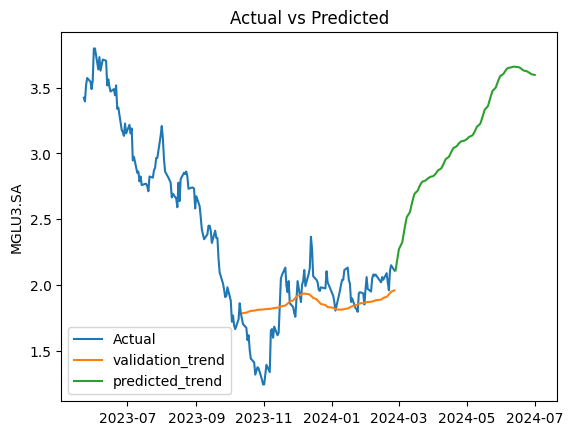

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
REDE D OR


1/1 [==============================] - 0s 46ms/step

___________________________________________________________________________
RDOR3.SA
Evaluation metric results:-
MSE is : 1.7802194723245761
MAE is : 1.0979523511495748
RMSE is : 1.334248654608494
MAPE is : 8.458611111569656
R2 is : 0.48335376104048355

Alta estimada: 23.62 %


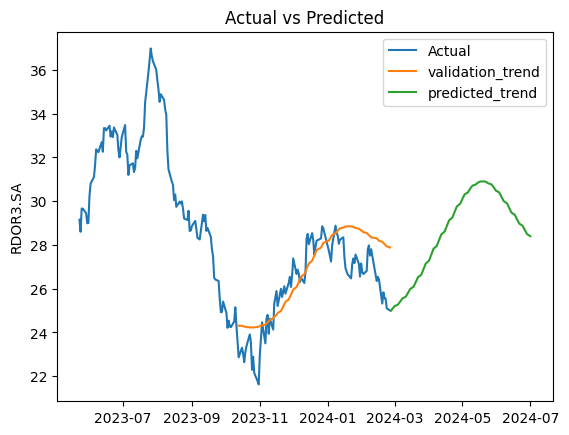


___________________________________________________________________________
___________________________________________________________________________
P.ACUCAR-CBD


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 29ms/step

___________________________________________________________________________
PCAR3.SA
Evaluation metric results:-
MSE is : 0.0850555763877204
MAE is : 0.22617758531401272
RMSE is : 0.29164289188615655
MAPE is : 8.536647215051058
R2 is : 0.20909272956685876

Alta estimada: 14.74 %


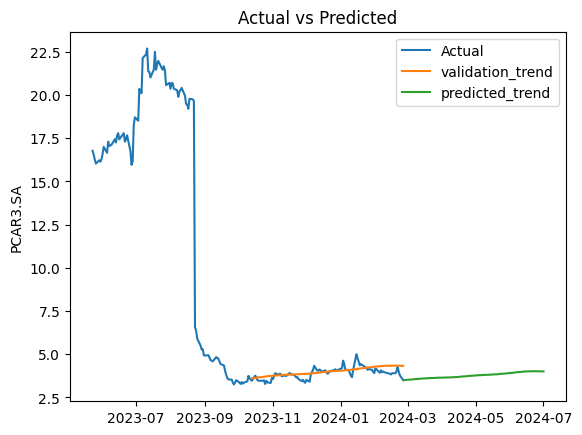

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
NEXTERA ENER


1/1 [==============================] - 0s 34ms/step

___________________________________________________________________________
NEXT34.SA
Evaluation metric results:-
MSE is : 6.296477881630982
MAE is : 2.136152917495888
RMSE is : 2.509278358738022
MAPE is : 3.3054423526243317
R2 is : 0.07286100324647904

Alta estimada: 13.31 %


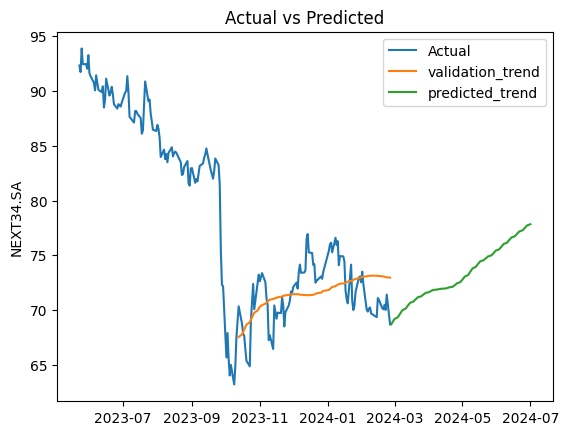

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
KRAFT HEINZ


1/1 [==============================] - 0s 32ms/step

___________________________________________________________________________
KHCB34.SA
Evaluation metric results:-
MSE is : 2.8082261199267475
MAE is : 1.458472461152613
RMSE is : 1.6757762738285644
MAPE is : 5.705933356055491
R2 is : 0.5229516353534731

Alta estimada: 12.33 %


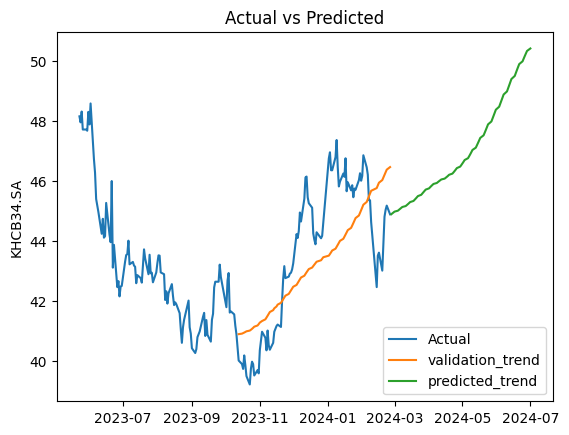

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
PALOALTO NET


1/1 [==============================] - 0s 33ms/step

___________________________________________________________________________
P2AN34.SA
Evaluation metric results:-
MSE is : 8.335484144548895
MAE is : 2.171010447358807
RMSE is : 2.887123853344171
MAPE is : 11.781159032226798
R2 is : 0.20766771209051127

Alta estimada: 11.9 %


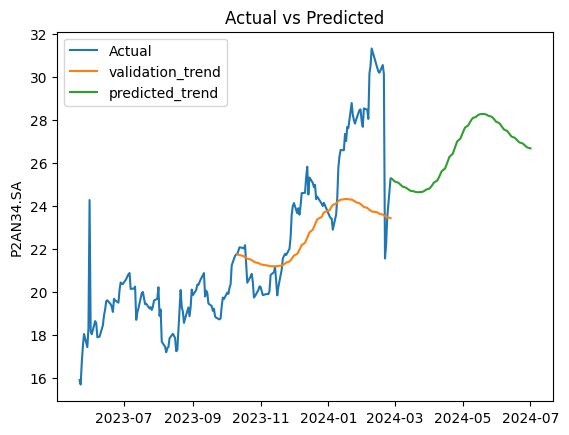

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
TEXAS INC


1/1 [==============================] - 0s 31ms/step

___________________________________________________________________________
TEXA34.SA
Evaluation metric results:-
MSE is : 7.960523721390007
MAE is : 2.263859806218802
RMSE is : 2.821440008469081
MAPE is : 4.743105651141988
R2 is : -0.08303159920517311

Alta estimada: 11.59 %


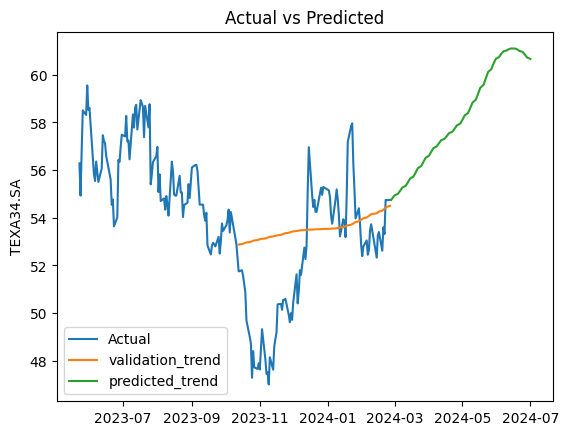

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
SANTANDER


1/1 [==============================] - 0s 36ms/step

___________________________________________________________________________
BCSA34.SA
Evaluation metric results:-
MSE is : 0.513632785078217
MAE is : 0.6292395637868493
RMSE is : 0.7166817878795421
MAPE is : 3.774904360522525
R2 is : 0.18651247241450442

Alta estimada: 11.05 %


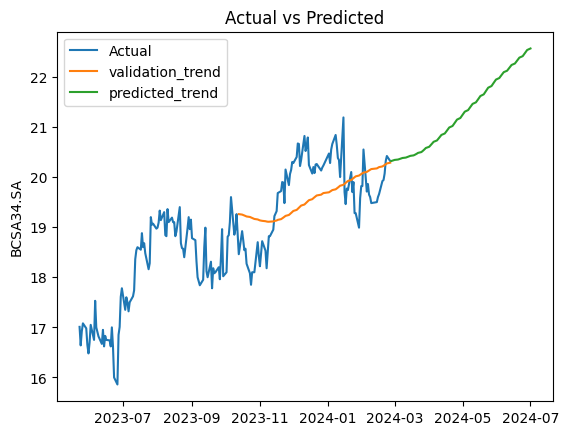

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
ZOETIS INC


1/1 [==============================] - 0s 38ms/step

___________________________________________________________________________
Z1TS34.SA
Evaluation metric results:-
MSE is : 9.250158046234521
MAE is : 2.3453749740453174
RMSE is : 3.041407247679028
MAPE is : 6.202990275271465
R2 is : 0.3154415767901806

Alta estimada: 10.13 %


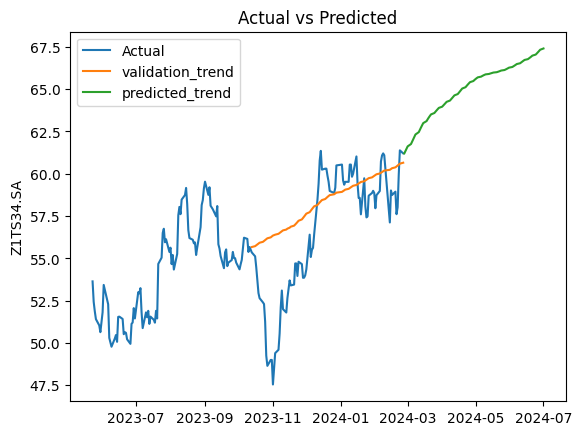

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
VIVARA S.A.


1/1 [==============================] - 0s 32ms/step

___________________________________________________________________________
VIVA3.SA
Evaluation metric results:-
MSE is : 6.380868288996079
MAE is : 2.1257318998545376
RMSE is : 2.526038061668129
MAPE is : 10.603600489595728
R2 is : 0.42339323420992425

Alta estimada: 10.12 %


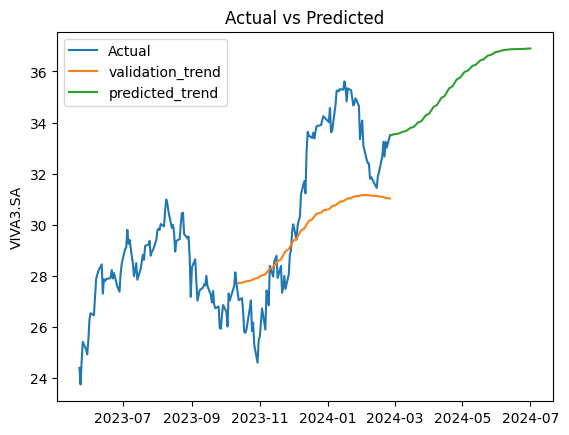

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
LLOYDS BANKI


1/1 [==============================] - 0s 47ms/step

___________________________________________________________________________
L1YG34.SA
Evaluation metric results:-
MSE is : 0.41003843402372386
MAE is : 0.5305934037303648
RMSE is : 0.6403424349703242
MAPE is : 5.006775080865539
R2 is : 0.029587756225555872

Alta estimada: 9.0 %


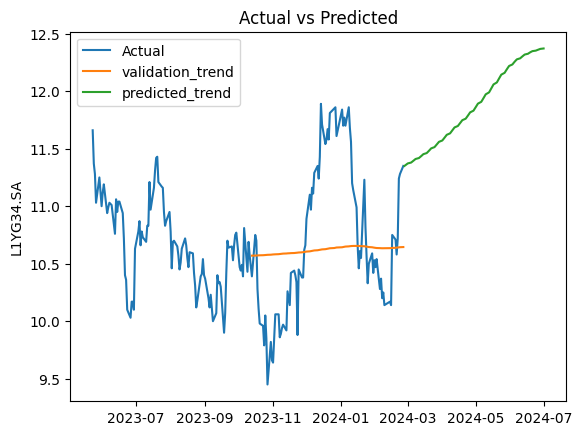

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
PRINER


1/1 [==============================] - 0s 30ms/step

___________________________________________________________________________
PRNR3.SA
Evaluation metric results:-
MSE is : 0.18427664872292315
MAE is : 0.3334095273466952
RMSE is : 0.4292745610013749
MAPE is : 3.6540906189912437
R2 is : 0.10156661095134412

Alta estimada: 8.02 %


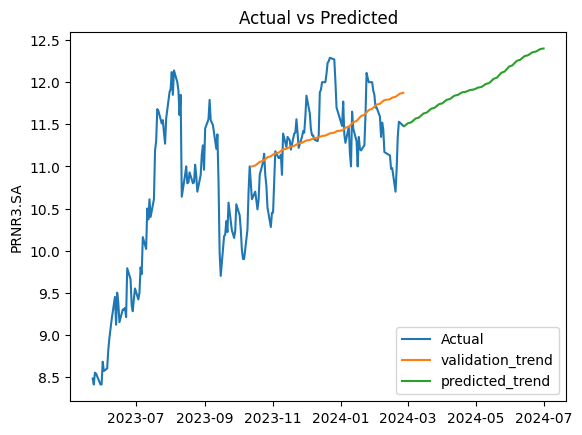

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
MONSTER BEVE


1/1 [==============================] - 0s 37ms/step

___________________________________________________________________________
M1NS34.SA
Evaluation metric results:-
MSE is : 1.6778250976279765
MAE is : 1.099700052629504
RMSE is : 1.2953088811661781
MAPE is : 5.086349974011862
R2 is : -0.042079040726736405

Alta estimada: 7.52 %


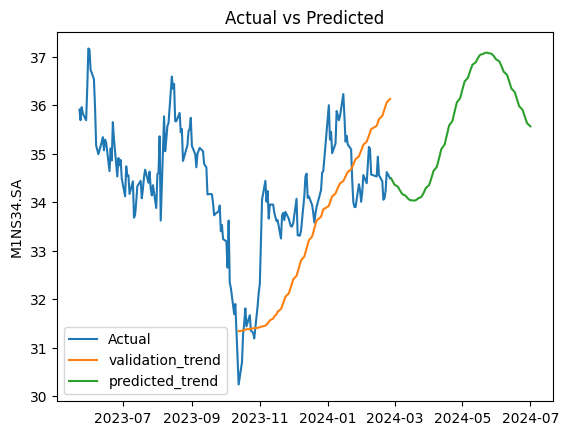


___________________________________________________________________________
___________________________________________________________________________
SAO CARLOS


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 32ms/step

___________________________________________________________________________
SCAR3.SA
Evaluation metric results:-
MSE is : 2.6464256881936716
MAE is : 1.37748007199717
RMSE is : 1.6267838480245835
MAPE is : 7.155262500550205
R2 is : 0.30561406791663503

Alta estimada: 7.16 %


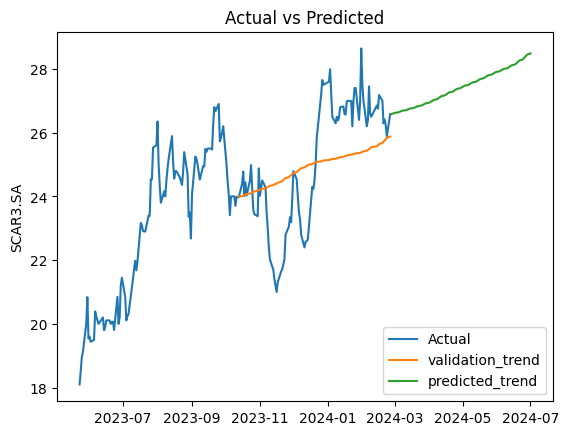


___________________________________________________________________________
___________________________________________________________________________
OUROFINO S/A


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 39ms/step

___________________________________________________________________________
OFSA3.SA
Evaluation metric results:-
MSE is : 2.9607209916016117
MAE is : 1.3248962075017148
RMSE is : 1.7206745745787062
MAPE is : 7.435490801287761
R2 is : 0.23721075972836114

Alta estimada: 6.78 %


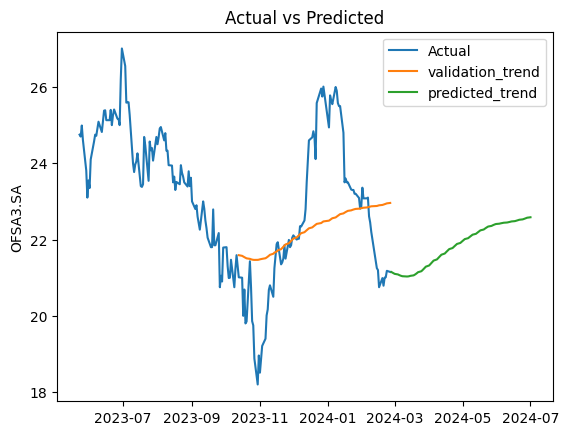


___________________________________________________________________________
___________________________________________________________________________
LILLY


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 30ms/step

___________________________________________________________________________
LILY34.SA
Evaluation metric results:-
MSE is : 98.38279913344435
MAE is : 8.336823437074155
RMSE is : 9.918810368862001
MAPE is : 8.870836224620579
R2 is : 0.09891617733611913

Alta estimada: 5.58 %


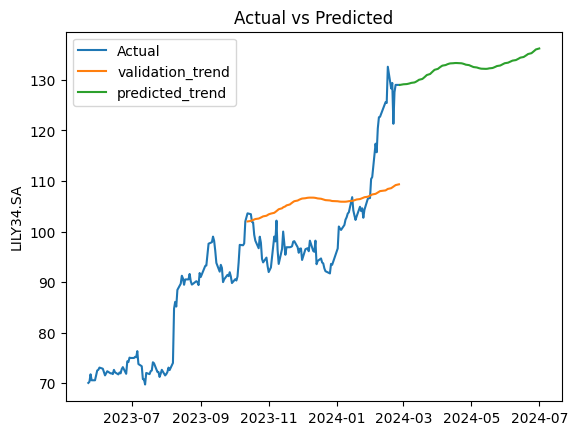

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
REALTY INCOM


1/1 [==============================] - 0s 50ms/step

___________________________________________________________________________
R1IN34.SA
Evaluation metric results:-
MSE is : 28.025443300037843
MAE is : 4.285837586615384
RMSE is : 5.293906242089847
MAPE is : 4.486245091613997
R2 is : 0.40132515494574816

Alta estimada: 5.58 %


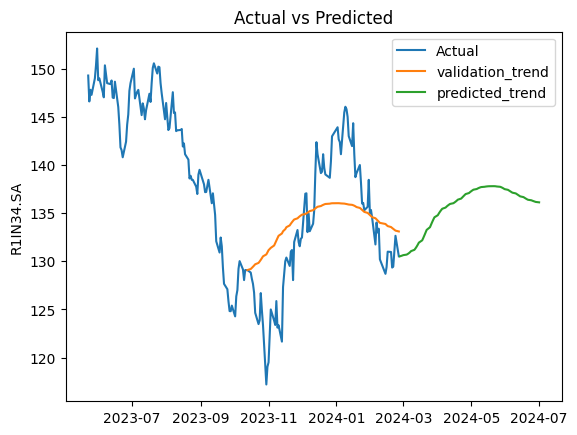

[*********************100%%**********************]  1 of 1 completed


___________________________________________________________________________
___________________________________________________________________________
VISA INC


1/1 [==============================] - 0s 33ms/step

___________________________________________________________________________
VISA34.SA
Evaluation metric results:-
MSE is : 12.358199204556993
MAE is : 2.758264621268019
RMSE is : 3.5154230477365016
MAPE is : 5.23586646850605
R2 is : 0.005878267465613152

Alta estimada: 5.01 %


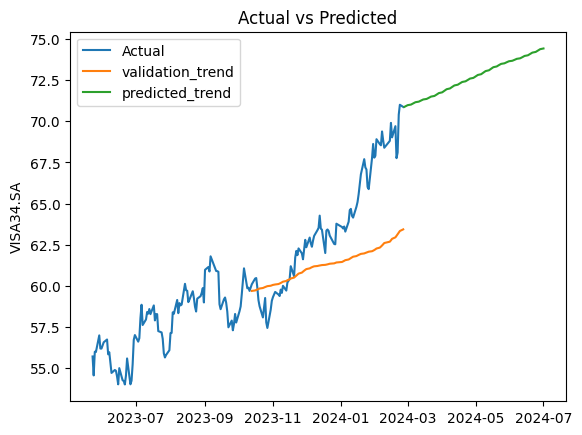

In [12]:
for i,t in zip(sugestoes_df["Asset"],sugestoes_df["empresa"]):
  print()
  print("_"*75)
  print("_"*75)
  print(t)
  preve_acao(i+".SA",True)

In [13]:
tickers = [ticker+".SA" for ticker in sugestoes_df["Asset"]]
tickers.append("^BVSP")
tickers.append("USDBRL=X")
startdate =  date(2023,1,1)
enddate = date.today()
data = get(tickers,startdate,enddate)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [14]:
analise_sugestoes_df = pd.DataFrame(data["Close"])
analise_sugestoes_df.reset_index(inplace=True)
analise_sugestoes_df.set_index("Date",inplace=True)
coor = analise_sugestoes_df.pivot_table(index="Date",columns="Ticker",values="Close").corr()
coor.style.background_gradient(cmap='coolwarm')

Ticker,BCSA34.SA,KHCB34.SA,L1YG34.SA,LILY34.SA,M1NS34.SA,MGLU3.SA,NEXT34.SA,OFSA3.SA,P2AN34.SA,PCAR3.SA,PRNR3.SA,R1IN34.SA,RDOR3.SA,SCAR3.SA,TEXA34.SA,USDBRL=X,VISA34.SA,VIVA3.SA,Z1TS34.SA,^BVSP
Ticker,,,,,,,,,,,,,,,,,,,,
BCSA34.SA,1.000000,-0.205492,0.031488,0.440583,-0.173048,-0.491282,-0.529172,-0.170104,0.554665,-0.502630,0.468937,-0.267436,-0.201264,0.342220,-0.197823,-0.105658,0.667239,0.479094,0.619415,0.477282
KHCB34.SA,-0.205492,1.000000,0.846005,-0.652648,-0.007148,0.618843,0.778386,0.676461,-0.554085,0.486377,-0.768484,0.871390,-0.202500,-0.756306,0.731342,0.659591,-0.209598,-0.591185,-0.158129,-0.529180
L1YG34.SA,0.031488,0.846005,1.000000,-0.690926,-0.188065,0.613097,0.686578,0.720898,-0.567506,0.495260,-0.687126,0.877692,-0.111302,-0.754798,0.773390,0.597799,-0.228285,-0.537801,-0.095474,-0.470202
LILY34.SA,0.440583,-0.652648,-0.690926,1.000000,0.106268,-0.802823,-0.876461,-0.705377,0.851821,-0.792767,0.815088,-0.836030,-0.034403,0.877712,-0.755306,-0.445689,0.795148,0.792617,0.554012,0.792782
M1NS34.SA,-0.173048,-0.007148,-0.188065,0.106268,1.000000,0.230335,0.060138,0.185888,0.140945,0.170635,0.138604,-0.024088,0.384859,0.186859,-0.027677,-0.388139,0.052062,0.278301,0.330481,0.160291
MGLU3.SA,-0.491282,0.618843,0.613097,-0.802823,0.230335,1.000000,0.821773,0.776849,-0.676335,0.824490,-0.707261,0.800322,0.265378,-0.746704,0.730350,0.243091,-0.589238,-0.572862,-0.297791,-0.597381
NEXT34.SA,-0.529172,0.778386,0.686578,-0.876461,0.060138,0.821773,1.000000,0.727379,-0.822766,0.793877,-0.827748,0.891183,0.065438,-0.803208,0.811265,0.483635,-0.639264,-0.747178,-0.445151,-0.732332
OFSA3.SA,-0.170104,0.676461,0.720898,-0.705377,0.185888,0.776849,0.727379,1.000000,-0.475116,0.683416,-0.527395,0.829275,0.285115,-0.597346,0.774198,0.191762,-0.364818,-0.306894,-0.041303,-0.326174
P2AN34.SA,0.554665,-0.554085,-0.567506,0.851821,0.140945,-0.676335,-0.822766,-0.475116,1.000000,-0.682321,0.759953,-0.706408,0.033471,0.783323,-0.564213,-0.499479,0.788260,0.856432,0.580876,0.807386


In [15]:
sugestoes_df

,Asset,Alta_estimada (%),Baixa_estimada (%),MAPE,r2,empresa
0,MGLU3,73.42,0.00,12.140222,0.181659,MAGAZ LUIZA
1,RDOR3,23.62,0.00,8.458611,0.483354,REDE D OR
2,PCAR3,14.74,0.00,8.536647,0.209093,P.ACUCAR-CBD
3,NEXT34,13.31,0.00,3.305442,0.072861,NEXTERA ENER
4,KHCB34,12.33,0.00,5.705933,0.522952,KRAFT HEINZ
5,P2AN34,11.90,-2.51,11.781159,0.207668,PALOALTO NET
6,TEXA34,11.59,0.00,4.743106,-0.083032,TEXAS INC
7,BCSA34,11.05,0.00,3.774904,0.186512,SANTANDER
8,Z1TS34,10.13,0.00,6.202990,0.315442,ZOETIS INC
9,VIVA3,10.12,0.00,10.603600,0.423393,VIVARA S.A.


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 51ms/step

___________________________________________________________________________
PCAR3.SA
Evaluation metric results:-
MSE is : 0.0850555763877204
MAE is : 0.22617758531401272
RMSE is : 0.29164289188615655
MAPE is : 8.536647215051058
R2 is : 0.20909272956685876

Alta estimada: 14.74 %


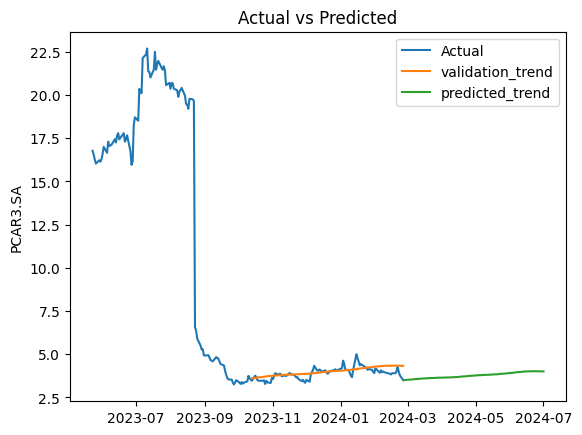

[14.74, 0.0, 8.536647215051058, 0.20909272956685876]

In [16]:
preve_acao("PCAR3.SA",True)